In [1]:
import pandas as pd
import numpy as np
import sklearn
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
directory = os.getcwd() + '\\'
filename = 'training.csv'
file_dir = directory + filename

In [3]:
"""
Copyright (C) 2008 Leonard Norrgard <leonard.norrgard@gmail.com>
Copyright (C) 2015 Leonard Norrgard <leonard.norrgard@gmail.com>

This file is part of Geohash.

Geohash is free software: you can redistribute it and/or modify it
under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

Geohash is distributed in the hope that it will be useful, but WITHOUT
ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or
FITNESS FOR A PARTICULAR PURPOSE.  See the GNU Affero General Public
License for more details.

You should have received a copy of the GNU Affero General Public
License along with Geohash.  If not, see
<http://www.gnu.org/licenses/>.
"""
from math import log10

#  Note: the alphabet in geohash differs from the common base32
#  alphabet described in IETF's RFC 4648
#  (http://tools.ietf.org/html/rfc4648)
__base32 = '0123456789bcdefghjkmnpqrstuvwxyz'
__decodemap = { }
for i in range(len(__base32)):
    __decodemap[__base32[i]] = i
del i

def decode_exactly(geohash):
    """
    Decode the geohash to its exact values, including the error
    margins of the result.  Returns four float values: latitude,
    longitude, the plus/minus error for latitude (as a positive
    number) and the plus/minus error for longitude (as a positive
    number).
    """
    lat_interval, lon_interval = (-90.0, 90.0), (-180.0, 180.0)
    lat_err, lon_err = 90.0, 180.0
    is_even = True
    for c in geohash:
        cd = __decodemap[c]
        for mask in [16, 8, 4, 2, 1]:
            if is_even: # adds longitude info
                lon_err /= 2
                if cd & mask:
                    lon_interval = ((lon_interval[0]+lon_interval[1])/2, lon_interval[1])
                else:
                    lon_interval = (lon_interval[0], (lon_interval[0]+lon_interval[1])/2)
            else:      # adds latitude info
                lat_err /= 2
                if cd & mask:
                    lat_interval = ((lat_interval[0]+lat_interval[1])/2, lat_interval[1])
                else:
                    lat_interval = (lat_interval[0], (lat_interval[0]+lat_interval[1])/2)
            is_even = not is_even
    lat = (lat_interval[0] + lat_interval[1]) / 2
    lon = (lon_interval[0] + lon_interval[1]) / 2
    return lat, lon, lat_err, lon_err

def decode(geohash):
    """
    Decode geohash, returning two strings with latitude and longitude
    containing only relevant digits and with trailing zeroes removed.
    """
    lat, lon, lat_err, lon_err = decode_exactly(geohash)
    # Format to the number of decimals that are known
    lats = "%.*f" % (max(1, int(round(-log10(lat_err)))) - 1, lat)
    lons = "%.*f" % (max(1, int(round(-log10(lon_err)))) - 1, lon)
    if '.' in lats: lats = lats.rstrip('0')
    if '.' in lons: lons = lons.rstrip('0')
    return lats, lons

def encode(latitude, longitude, precision=12):
    """
    Encode a position given in float arguments latitude, longitude to
    a geohash which will have the character count precision.
    """
    lat_interval, lon_interval = (-90.0, 90.0), (-180.0, 180.0)
    geohash = []
    bits = [ 16, 8, 4, 2, 1 ]
    bit = 0
    ch = 0
    even = True
    while len(geohash) < precision:
        if even:
            mid = (lon_interval[0] + lon_interval[1]) / 2
            if longitude > mid:
                ch |= bits[bit]
                lon_interval = (mid, lon_interval[1])
            else:
                lon_interval = (lon_interval[0], mid)
        else:
            mid = (lat_interval[0] + lat_interval[1]) / 2
            if latitude > mid:
                ch |= bits[bit]
                lat_interval = (mid, lat_interval[1])
            else:
                lat_interval = (lat_interval[0], mid)
        even = not even
        if bit < 4:
            bit += 1
        else:
            geohash += __base32[ch]
            bit = 0
            ch = 0
    return ''.join(geohash)

In [4]:
df = pd.read_csv(file_dir)

In [5]:
# Preprocessing
df.insert(2,'hour', df.timestamp.apply(lambda x : int(x.split(':')[0])))
df.insert(3,'minute', df.timestamp.apply(lambda x : int(x.split(':')[1])))
df.insert(1,'geohash6_proc',df.geohash6.apply(lambda x : decode_exactly(x)))
df.insert(2,'latitude',df.geohash6_proc.apply(lambda x : x[0]))
df.insert(3,'longtitude',df.geohash6_proc.apply(lambda x : x[1]))
df.insert(4,'latitude_error',df.geohash6_proc.apply(lambda x : x[2]))
df.insert(5,'longtitude_error',df.geohash6_proc.apply(lambda x : x[3]))
df.insert(9,'day_of_week', df['day'].apply(lambda x : (x % 7) - 1))
df['day_of_week'] = df['day_of_week'].replace(-1, 6)
df = df.sort_values(by = ['day','hour', 'minute'])
mid_lat = (df['latitude'].max() + df['latitude'].min()) / 2
mid_long = (df['longtitude'].max() + df['longtitude'].min()) / 2
df.insert(7,'North', df['latitude'] > mid_lat)
df['North'] = df['North'].replace(False, int(0))
df['North'] = df['North'].replace(True, int(1))
df.insert(8,'East', df['longtitude'] > mid_long)
df['East'] = df['East'].replace(False, int(0))
df['East'] = df['East'].replace(True, int(1))
df.insert(9,'North_East', df['North'].astype('str') + ',' + df['East'].astype('str'))

Text(0.5, 1.0, 'Geohash6 counts')

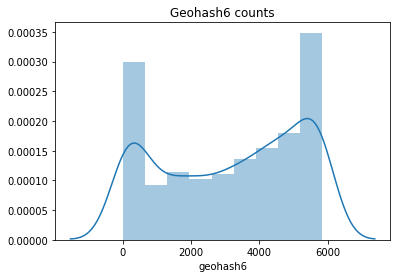

In [11]:
sns.distplot(df.geohash6.value_counts(), hist=True, rug=False)
plt.title('Geohash6 counts')

As seen above, there are 2 main bins which are the bars on the extreme end. This of course will be an obstacle to deal with later during training as the time series for each region are not the same.

Text(0.5, 1.0, 'Demand distribution')

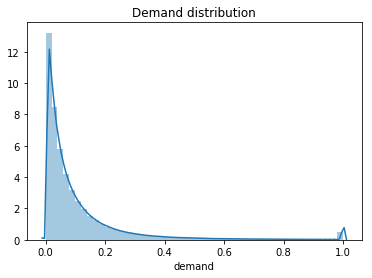

In [12]:
sns.distplot(df['demand'], hist=True, rug=False)
plt.title('Demand distribution')

The above demand distribution plot indicates that a large part of the demand is actually skewed towards the the lower end with a very small peak at 1, reflecting demands are usually not that high and only certain occasions that the demand spike.

Text(0.5, 1.0, 'Latitude distribution')

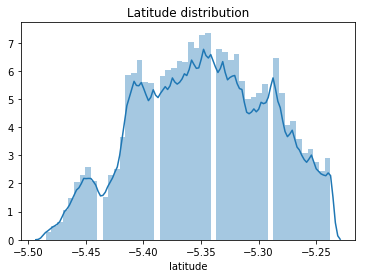

In [13]:
sns.distplot(df['latitude'], hist=True, rug=False)
plt.title('Latitude distribution')

The distribution of latitude data indicates that the there are more regions at the center with respect to the given data. If comparing the extreme ends, there are more regions present in the east as compared to the west side with respect to the central area of the data provided

Text(0.5, 1.0, 'Boxplot of different days of the week')

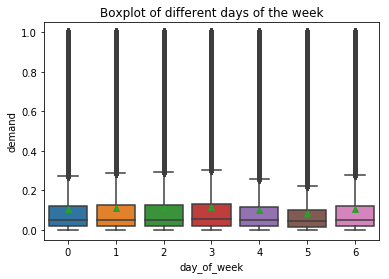

In [15]:
sns.boxplot(df['day_of_week'], df['demand'],showmeans=True)
plt.title('Boxplot of different days of the week')

Looking at the boxplot distribution of demands throughout a week (though we do not know which day is it as no information was provided), we are able to see that for days 4 and 5, there are lower demands in general from both the mean and the range of the quantiles. Nevertheless, all days have periods with maximum demand

Text(0.5, 1.0, 'Plot of counts of occurence for each hour')

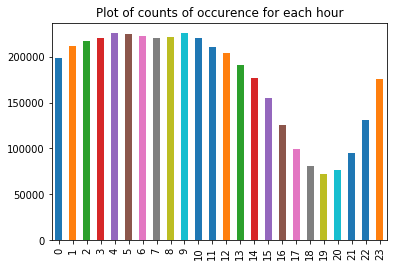

In [17]:
df['hour'].value_counts().sort_index().plot(kind = 'bar')
plt.title('Plot of counts of occurence for each hour')

Interestingly, there are lesser demands at night in comparison to past 12 mightnight till morning. Demand starts to dip after 10am generally. My guesses are past 12 midnight, lack of transport 

Text(0.5, 1.0, 'Boxplot of different hours in all days')

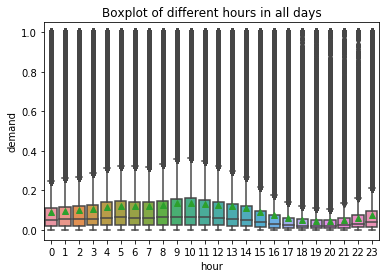

In [6]:
sns.boxplot(df['hour'], df['demand'],showmeans=True)
plt.title('Boxplot of different hours in all days')

As seen above, it reflects the same idea as

Text(0.5, 1.0, 'Boxplot of different hours in all days')

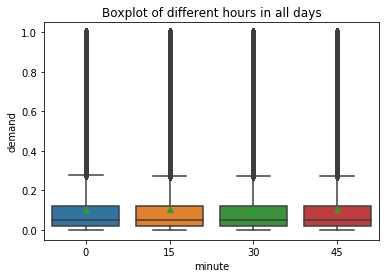

In [7]:
sns.boxplot(df['minute'], df['demand'],showmeans=True)
plt.title('Boxplot of different hours in all days')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]),
 <a list of 96 Text xticklabel objects>)

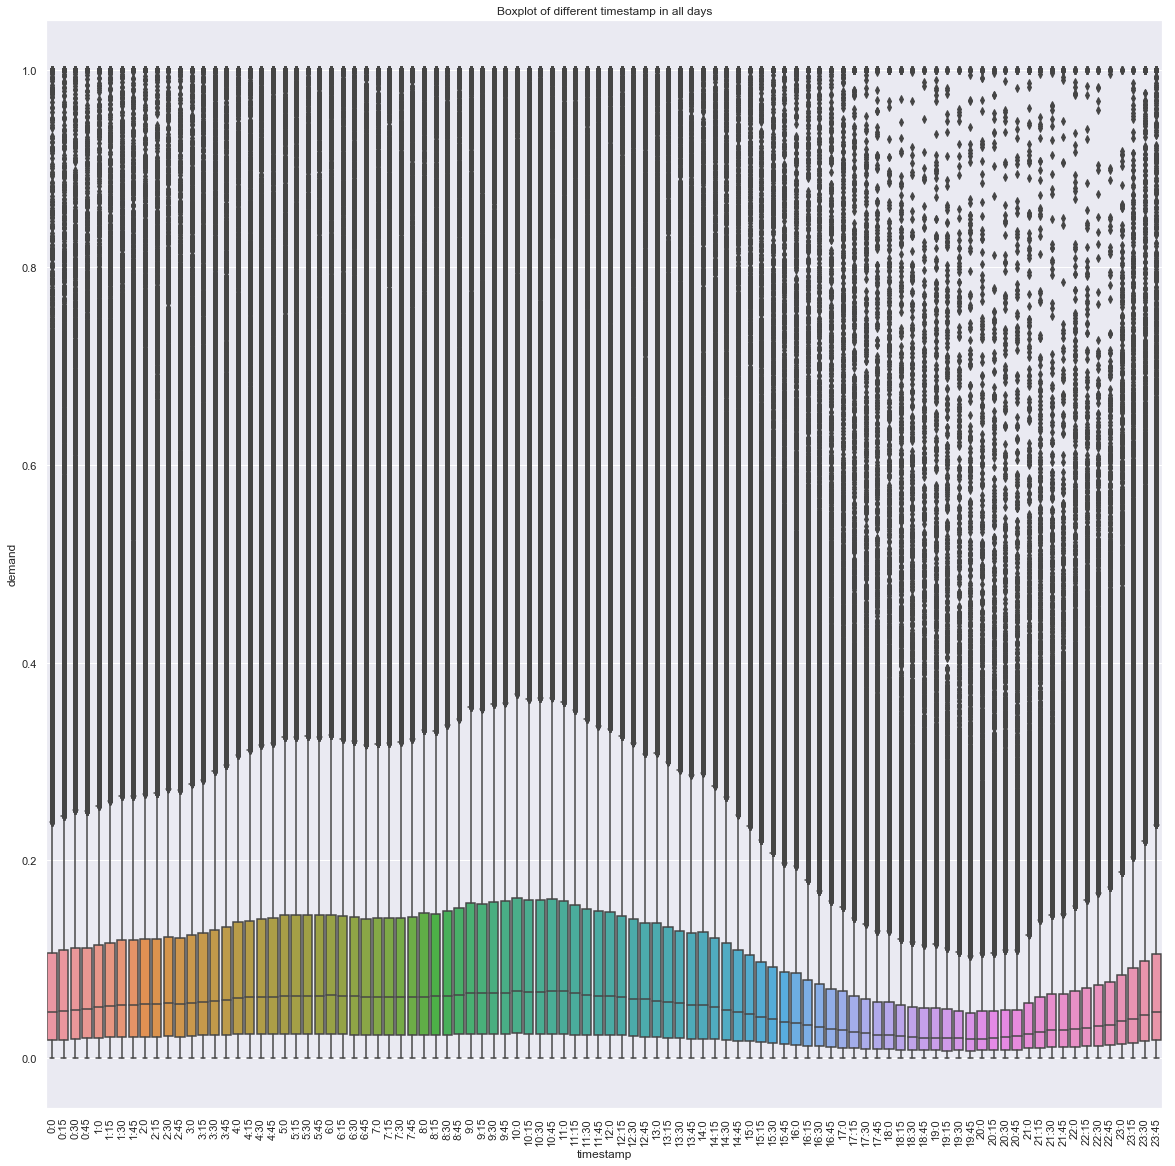

In [11]:
sns.set(rc={'figure.figsize':(20,20)})
sns.boxplot(df['timestamp'], df['demand'])
plt.title('Boxplot of different timestamp in all days')
plt.xticks(rotation=90)

Likewise when plotting for all the timestamps, it shows a similar pattern to the hours with the demand droppin at night

Text(0.5, 1.0, 'North vs South demand')

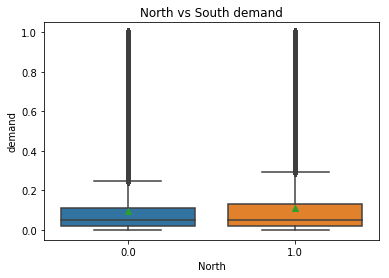

In [8]:
sns.boxplot(df['North'], df['demand'],showmeans=True)
plt.title('North vs South demand')

Now in terms of region, we are separating into North and South, with 1 being North and 0 being South. It appears that there are more demand in the North than in the South.

Text(0.5, 1.0, 'East vs West demand')

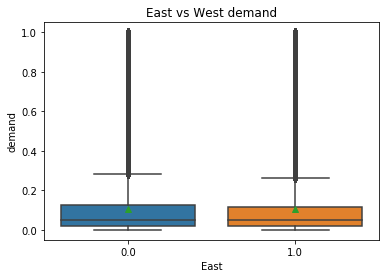

In [9]:
sns.boxplot(df['East'], df['demand'],showmeans=True)
plt.title('East vs West demand')

Now for East and West, with 1 being East and 0 being West, it appears that there are more demand in the West than in the East.

Text(0.5, 0, 'North,South,East,West')

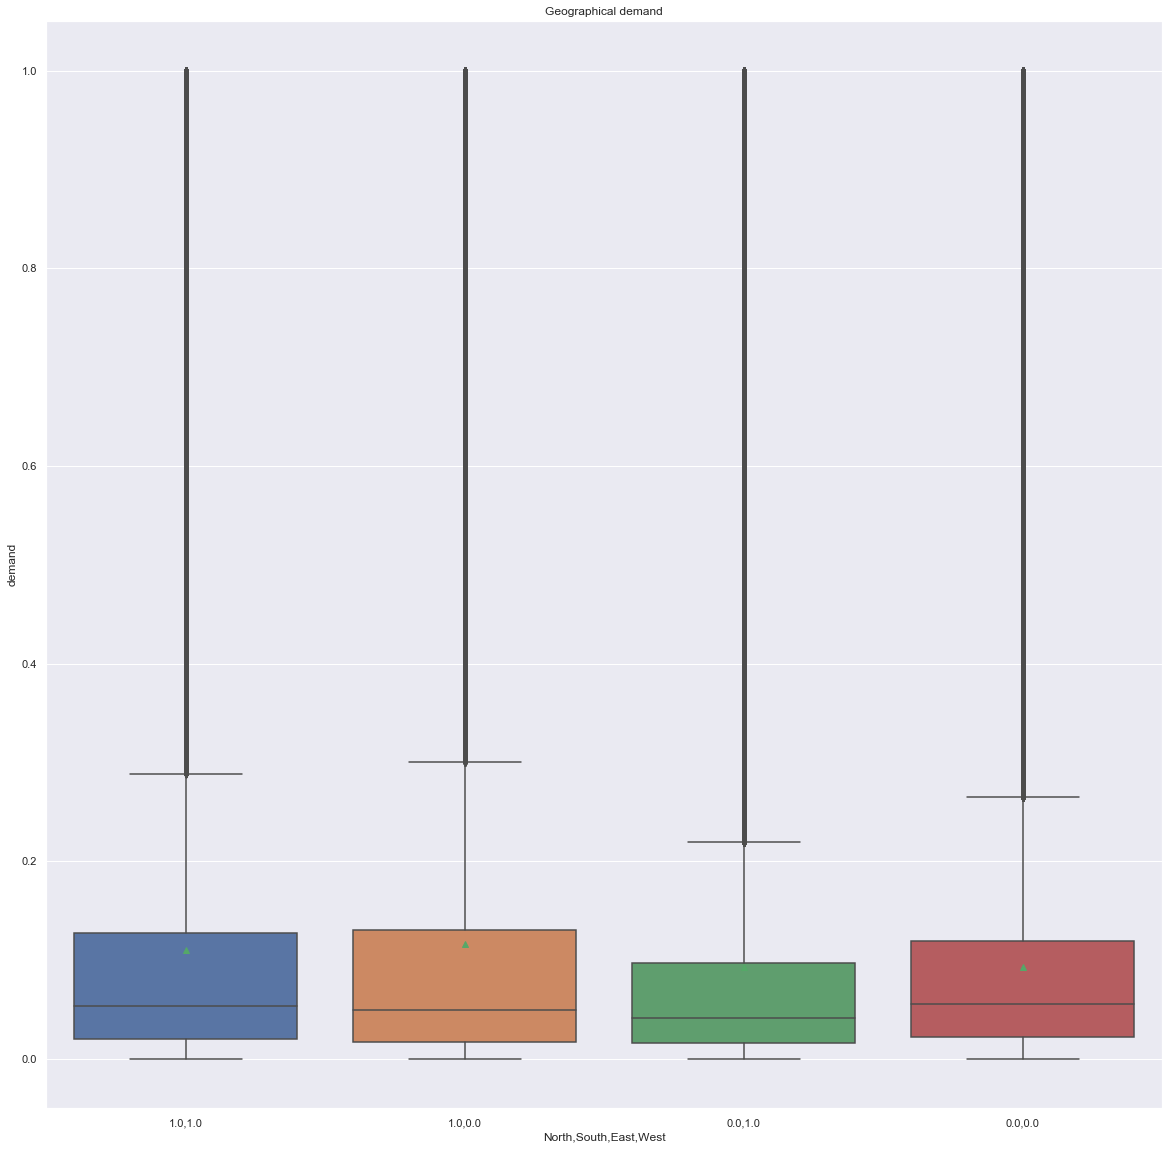

In [13]:
sns.boxplot(df['North_East'], df['demand'],showmeans=True)
plt.title('Geographical demand')
plt.xlabel('North,South,East,West')

Overall in terms of North, South, East and West, most quadrants have approximately similar demands except for South-East, where lesser demands can be found